## Clustering of Microenvironments/Subgraphs

This notebook demonstrates how to use a trained GNN model to define microenvironment clusters

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import torch
import spacegm

from spacegm.embeddings_analysis import (
    get_random_sampled_subgraphs,
    get_embedding,
    get_composition_vector,
    get_composition_heatmap_for_cluster,
    dimensionality_reduction_combo,
    collect_cluster_label_for_all_nodes,
)

Load the example dataset (please (re-)run the notebook `Example.ipynb` to generate the dataset):

In [2]:
# Dataset containing 4 example regions
dataset_root = "data/example_dataset"
dataset_kwargs = {
    'raw_folder_name': 'graph',
    'processed_folder_name': 'tg_graph',
    'node_features': ["cell_type", "SIZE", "biomarker_expression", "neighborhood_composition", "center_coord"],
    'edge_features': ["edge_type", "distance"],
    'subgraph_size': 3,
    'subgraph_source': 'on-the-fly',
    'subgraph_allow_distant_edge': True,
    'subgraph_radius_limit': 200.,
}
dataset = spacegm.CellularGraphDataset(dataset_root, **dataset_kwargs)

# Transformers: add graph labels to the subgraphs, mask out features
transformers = [
    spacegm.AddGraphLabel('data/metadata/full_graph_labels.csv', tasks=['survival_status']),
    spacegm.FeatureMask(dataset, use_center_node_features=['cell_type', 'SIZE'], use_neighbor_node_features=['cell_type', 'SIZE']),
]
dataset.set_transforms(transformers)

Load a GNN model trained on the graph-level task:

In [3]:
model_kwargs = {
    'num_layer': dataset.subgraph_size,
    'num_node_type': len(dataset.cell_type_mapping) + 1,
    'num_feat': dataset[0].x.shape[1] - 1,
    'emb_dim': 512, 
    'num_node_tasks': 0,
    'num_graph_tasks': 1,  # a binary classification task
    'node_embedding_output': 'last', 
    'drop_ratio': 0.25, 
    'graph_pooling': "max", 
    'gnn_type': 'gin',
}

model = spacegm.GNN_pred(**model_kwargs)
device = 'cuda:0'
model.load_state_dict(torch.load('data/example_model_weights.pt'))

display(model)

GNN_pred(
  (gnn): GNN(
    (x_embedding): Embedding(17, 512)
    (feat_embedding): Linear(in_features=41, out_features=512, bias=True)
    (gnns): ModuleList(
      (0-2): 3 x GINConv()
    )
    (batch_norms): ModuleList(
      (0-2): 3 x BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_module): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)

Generate model predictions on the example regions and calculate metric:

In [4]:
# Evaluation by iterating over the full graph
node_preds, graph_preds = spacegm.inference.collect_predict_for_all_nodes(
    model, dataset, device, inds=np.arange(4), print_progress=True)

# Aggregated (average) predictions of each region
for i, pred in graph_preds.items():
    region_id = dataset[i].region_id
    predicted_prob = 1 / (1 + np.exp(-np.array(pred)))  # Sigmoid
    avg_pred = np.mean(predicted_prob)
    print("On region %s, average prediction: %.3f" % (region_id, avg_pred))

spacegm.inference.full_graph_graph_classification_evaluate_fn(dataset, graph_preds, print_res=True)

predict on 0
predict on 1
predict on 2
predict on 3
On region UPMC_c001_v001_r001_reg001, average prediction: 0.333
On region UPMC_c001_v001_r001_reg004, average prediction: 0.389
On region UPMC_c001_v001_r001_reg009, average prediction: 0.554
On region UPMC_c001_v001_r001_reg014, average prediction: 0.505
GRAPH [1.0]


[1.0]

To define microenvironment clusters, we first randomly sample subgraphs from the dataset as reference:

In [5]:
reference_subgraph_list = get_random_sampled_subgraphs(dataset, n_samples=32768)

Calculate the GNN embeddings and composition vectors of the reference subgraphs:

In [6]:
ref_node_embeddings, ref_graph_embeddings, (ref_node_preds, ref_graph_preds) = \
    get_embedding(model, reference_subgraph_list, device)
ref_composition_vectors = [
    get_composition_vector(data, n_cell_types=len(dataset.cell_type_mapping))
    for data in reference_subgraph_list
]

Here we use graph embedding as an example and fit dimensionality reduction and clustering models on them.

A list of fitted models will be returned:
1. a scikit-learn based PCA object `sklearn.decomposition.PCA`
2. a UMAP reducer (if UMAP is installed) `umap.UMAP`
3. a clustering model: e.g., `sklearn.cluster.KMeans`

In [7]:
ref_pca_embs, ref_umap_emb, ref_cluster_labels, (pca, reducer, km_clustering) = \
    dimensionality_reduction_combo(
        ref_graph_embeddings, n_pca_components=20, cluster_method='kmeans', n_clusters=4)

Calculate and plot summary heatmaps for each neighborhood/microenvironment cluster (the composition of cell types in the neighborhoods)

In [8]:
heatmap, enrichment, cluster_preds, cluster_counts = \
    get_composition_heatmap_for_cluster(reference_subgraph_list, ref_cluster_labels, ref_graph_preds)

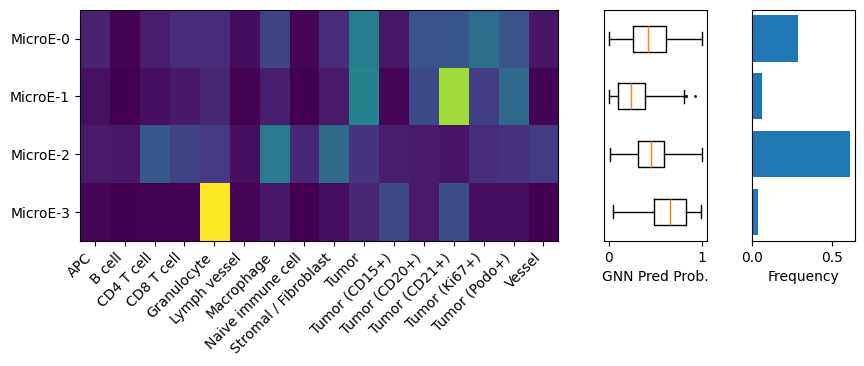

In [9]:
plot_cluster_labels = np.array(ref_cluster_labels).flatten()
plot_graph_preds = 1 / (1 + np.exp(-np.array(ref_graph_preds).flatten()))  # Sigmoid

ctm = dataset.cell_type_mapping
n_clusters = heatmap.shape[0]

f, (a0, a1, a2) = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw={'width_ratios': [14, 3, 3]})

# Heatmap of cell type enrichment
a0.imshow(heatmap, vmin=0, vmax=0.4, cmap='viridis', aspect='auto', extent=[0, len(ctm), 0, n_clusters])
a0.set_xticks(np.array([ctm[ct] for ct in sorted(ctm.keys())]) + 0.5,
              sorted(ctm.keys()), rotation=45, ha='right')
a0.set_yticks(np.arange(n_clusters - 1, -1, -1) + 0.5, ["MicroE-%d" % o for o in range(n_clusters)])

# Box plot of predicted probabilities for each neighborhood
xs = [plot_graph_preds[np.where(plot_cluster_labels == cl)[0]] for cl in range(n_clusters)]
a1.boxplot(xs, vert=False, positions=np.arange(n_clusters), flierprops=dict(marker='.', markersize=2))
a1.set_ylim(n_clusters - 0.5, -0.5)
a1.set_xlabel("GNN Pred Prob.")
a1.set_yticks([])

# Bar plot of neighborhood count in the sampled reference subgraphs
counts_ar = [len(x) for x in xs]
freq_ar = np.array(counts_ar)/np.sum(counts_ar)
a2.barh(np.arange(n_clusters), freq_ar, align='center')
a2.set_yticks([])
a2.set_ylim(n_clusters - 0.5, -0.5)
a2.set_xlabel("Frequency")

plt.show()

Apply the dimensionality reduction and clustering models on the entire dataset (all cells and their k-hop subgraphs):

In [11]:
cluster_labels = collect_cluster_label_for_all_nodes(
    model, dataset, device, pca_model=pca, cluster_label_pred_model=km_clustering,
    embedding_from='graph', print_progress=True)

Predict on 0
Predict on 1
Predict on 2
Predict on 3
